# Grant Terminations
data source: grant-witness.us

## Data Preprocessing

In [56]:
# imports
import pandas as pd
import re
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


Data

In [3]:
df_epa = pd.read_csv('../data/epa_terminations.csv')
print(df_epa.shape)
df_nih = pd.read_csv('../data/nih_terminations.csv')
print(df_nih.shape)
df_nsf = pd.read_csv('../data/nsf_terminations.csv')
print(df_nsf.shape)

(671, 30)
(5836, 56)
(1996, 40)


In [4]:
epa_cols = sorted(df_epa.columns)
nih_cols = sorted(df_nih.columns)
nsf_cols = sorted(df_nsf.columns)

shared_nihnsf_before = set(nsf_cols) | set(nih_cols)
shared_all_before = set(epa_cols) | set(nsf_cols) | set(nih_cols)
print(shared_all_before)


{'us_rep', 'us_rep_phone', 'award_frozen', 'total_award', 'core_award_number', 'nggs_url', 'directorate', 'usasp_obligation_hist', 'organization', 'foa', 'program_office', 'notes', 'nsf_start_date', 'gs_org', 'div', 'usasp_start_date', 'org_traits', 'phr_text', 'nsf_end_date', 'unfrozen_date', 'court_reported', 'reinstated', 'abstract', 'estimated_remaining', 'foa_title', 'usasp_total_obligated', 'funding_opportunity_number', 'org_county', 'taggs_url', 'usaspending_url', 'event_history', 'estimated_budget', 'grant_id', 'nsf_total_budget', 'last_payment_month', 'terminated', 'ever_frozen', 'targeted_start_date', 'nsf_url', 'total_estimated_remaining', 'org_state', 'award_value', 'usasp_outlaid', 'funding_opportunity_goals', 'org_city', 'project_title', 'start_date', 'award_region', 'cfda_title', 'org_type', 'org_zip', 'pct_ugrad_pellgrant', 'last_payment_date', 'nih_activity', 'nsf_program_name', 'termination_date', 'reinstatement_date', 'termination_indicator', 'estimated_outlays', 're

Making uniform columns

In [5]:
df_epa = df_epa.rename(columns={'grant_id': 'award_id', 'organization': 'org_name', 'original_end_date': 'end_date_original', 'project_description': 'abstract'})
df_nsf = df_nsf.rename(columns={'grant_id': 'award_id', 'ndf_end_date': 'end_date_original', 'nsf_start_date': 'start_date_original'})
df_nih = df_nih.rename(columns={'core_award_number': 'award_id', 'reinstated_est_date': 'reinstatement_date', 'project_end_date': 'end_date_original', 'abstract_text': 'abstract'})

In [6]:
# to make sure i know which is which
df_epa['agency'] = 'EPA'
df_nsf['agency'] = 'NSF'
df_nih['agency'] = 'NIH'

In [7]:
epa_cols = sorted(df_epa.columns)
nih_cols = sorted(df_nih.columns)
nsf_cols = sorted(df_nsf.columns)

shared_nihnsf = set(nsf_cols) | set(nih_cols)
shared_all = set(epa_cols) | set(nsf_cols) | set(nih_cols)
print(sorted(shared_all))


['abstract', 'activity_code', 'agency', 'appl_id', 'award_frozen', 'award_id', 'award_outlaid', 'award_region', 'award_remaining', 'award_type', 'award_value', 'cancellation_source', 'cfda_number', 'cfda_title', 'court_reported', 'court_restoration_url', 'cruz_list', 'dept_type', 'dir', 'directorate', 'div', 'division', 'end_date_original', 'estimated_budget', 'estimated_outlays', 'estimated_remaining', 'event_history', 'ever_frozen', 'file_c_outlays', 'flagged_words', 'foa', 'foa_title', 'frozen_date', 'full_award_number', 'funding_category', 'funding_opportunity_goals', 'funding_opportunity_number', 'gs_org', 'hhs_pdf_reported', 'hhs_web_reported', 'last_payment_date', 'last_payment_month', 'nggs_url', 'nih_activity', 'notes', 'nsf_end_date', 'nsf_obligated', 'nsf_primary_program', 'nsf_program_name', 'nsf_total_budget', 'nsf_url', 'org_city', 'org_congdist', 'org_county', 'org_name', 'org_state', 'org_traits', 'org_type', 'org_zip', 'pct_ugrad_fedloan', 'pct_ugrad_pellgrant', 'phr_t

Missing values overview

In [8]:
df_nih.isna().mean()

status                       0.000000
award_id                     0.000000
full_award_number            0.000000
hhs_web_reported             0.000000
hhs_pdf_reported             0.000000
self_reported                0.000000
court_reported               0.000000
source_reported              0.000000
targeted_start_date          0.492975
targeted_end_date            0.519877
ever_frozen                  0.000000
frozen_date                  0.492975
unfrozen_date                0.519877
file_c_outlays               0.492975
termination_date             0.441570
cancellation_source          0.000000
reinstatement_indicator      0.564085
reinstatement_date           0.564085
reinstatement_case           0.819568
last_payment_month           0.493317
last_payment_date            0.493317
project_title                0.003084
activity_code                0.003084
org_name                     0.003084
org_type                     0.003084
dept_type                    0.064428
program_offi

In [9]:
df_epa.isna().mean()

award_id                      0.000000
status                        0.000000
event_history                 0.000000
termination_date              0.004471
termination_indicator         0.002981
reinstatement_date            0.883756
reinstatement_indicator       0.885246
project_title                 0.000000
org_name                      0.000000
start_date                    0.000000
end_date_original             0.000000
award_value                   0.000000
award_outlaid                 0.113264
award_frozen                  0.988077
award_remaining               0.113264
notes                         0.988077
org_state                     0.000000
org_city                      0.000000
org_county                    0.000000
org_zip                       0.000000
abstract                      0.000000
org_type                      0.481371
award_region                  0.000000
gs_org                        0.551416
cfda_number                   0.000000
cfda_title               

In [10]:
df_nsf.isna().mean()

award_id                           0.000000
status                             0.000000
terminated                         0.000000
suspended                          0.318136
termination_date                   0.000000
termination_indicator              0.000000
reinstated                         0.000000
reinstatement_date                 0.682866
reinstatement_indicator            0.682866
cruz_list                          0.000000
nsf_url                            0.000000
usaspending_url                    0.000000
project_title                      0.002004
abstract                           0.002505
org_name                           0.002004
org_state                          0.002004
org_city                           0.002505
award_type                         0.002004
usasp_start_date                   0.001002
usasp_end_date                     0.001002
start_date_original                0.002004
nsf_end_date                       0.002004
nsf_program_name                

Create column with flagged words

In [11]:
with open('../data/banned_words_PEN.txt', encoding='utf-8') as f:
    pen_words = sorted(set(line.strip().casefold() for line in f if line.strip() and not line.startswith('#')))

with open('../data/banned_words.txt', encoding='utf-8') as f:
    nyt_words = sorted(set(line.strip().casefold() for line in f if line.strip() and not line.startswith('#')))

print(pen_words)
print(nyt_words)

['abortion', 'accessibility', 'accessible', 'activism', 'activists', 'advocacy', 'advocate', 'advocates', 'affirming care', 'affordable home', 'affordable housing', 'agricultural water', 'agrivoltaics', 'air pollution', 'all-inclusive', 'allyship', 'alternative energy', 'anti-racism', 'antiracist', 'asexual', 'assigned at birth', 'assigned female at birth', 'assigned male at birth', 'at risk', 'autism', 'aviation fuel', 'barrier', 'barriers', 'belong', 'bias', 'biased', 'biased toward', 'biases', 'biases towards', 'bioenergy', 'biofuel', 'biogas', 'biologically female', 'biologically male', 'biomethane', 'bipoc', 'bisexual', 'black', 'black and latinx', 'breastfeed + people', 'breastfeed + person', 'cancer moonshot', 'carbon emissions mitigation', 'carbon footprint', 'carbon markets', 'carbon pricing', 'carbon sequestration', 'cec', 'changing climate', 'chestfeed + people', 'chestfeed + person', 'clean energy', 'clean fuel', 'clean power', 'clean water', 'climate', 'climate accountabil

In [12]:
def words_and_phrases(words):
    single_words = []
    phrase_words = []
    for word in words:
        if ' ' in word:
            pattern = r'\s'.join(re.escape(p) for p in word.split())
            phrase_words.append((word, re.compile(r'(?i)' + pattern)))
        else:
            pattern = r'\b' + re.escape(word) + r'\b'
            single_words.append((word, re.compile(r'(?i)' + pattern)))
    return single_words, phrase_words

pen_single_words, pen_phrases = words_and_phrases(pen_words)
nyt_single_words, nyt_phrases = words_and_phrases(nyt_words)

In [13]:
pen_single_words

[('abortion', re.compile(r'(?i)\babortion\b', re.IGNORECASE|re.UNICODE)),
 ('accessibility',
  re.compile(r'(?i)\baccessibility\b', re.IGNORECASE|re.UNICODE)),
 ('accessible', re.compile(r'(?i)\baccessible\b', re.IGNORECASE|re.UNICODE)),
 ('activism', re.compile(r'(?i)\bactivism\b', re.IGNORECASE|re.UNICODE)),
 ('activists', re.compile(r'(?i)\bactivists\b', re.IGNORECASE|re.UNICODE)),
 ('advocacy', re.compile(r'(?i)\badvocacy\b', re.IGNORECASE|re.UNICODE)),
 ('advocate', re.compile(r'(?i)\badvocate\b', re.IGNORECASE|re.UNICODE)),
 ('advocates', re.compile(r'(?i)\badvocates\b', re.IGNORECASE|re.UNICODE)),
 ('agrivoltaics',
  re.compile(r'(?i)\bagrivoltaics\b', re.IGNORECASE|re.UNICODE)),
 ('all-inclusive',
  re.compile(r'(?i)\ball\-inclusive\b', re.IGNORECASE|re.UNICODE)),
 ('allyship', re.compile(r'(?i)\ballyship\b', re.IGNORECASE|re.UNICODE)),
 ('anti-racism',
  re.compile(r'(?i)\banti\-racism\b', re.IGNORECASE|re.UNICODE)),
 ('antiracist', re.compile(r'(?i)\bantiracist\b', re.IGNOREC

In [14]:
def flag_in_abstract(abstract, words, phrases):
    if pd.isna(abstract):
        return set()
    text = str(abstract)
    found_words = set()
    for word, pattern in words:
        if pattern.search(text):
            found_words.add(word)
    for word, patter in phrases:
        if pattern.search(text):
            found_words.add(word)
    return found_words

In [15]:
# for nih specifically
def parse_nih_flagged_words(cell):
    if pd.isna(cell):
        return set()
    parts = re.split(r'[,\n;|]+', str(cell))
    cleaned = {p.strip().casefold() for p in parts if p.strip()}
    return cleaned

In [16]:
def add_flagged_column(df):
    pen_flagged = []
    nyt_flagged = []
    all_flagged = []

    for i, row in df.iterrows():
        abstract = row['abstract']
        pen_found = flag_in_abstract(abstract, pen_single_words, pen_phrases)
        nyt_found = flag_in_abstract(abstract, nyt_single_words, nyt_phrases)
        existing_found = ()
        if 'flagged_words' in df.columns:
            existing_found = parse_nih_flagged_words(row['flagged_words'])
            existing_found = set(existing_found)
        else:
            existing_found = set()
        combined_found = pen_found | nyt_found | existing_found
        pen_flagged.append(pen_found)
        nyt_flagged.append(nyt_found)
        all_flagged.append(combined_found)

    df['flagged_words_pen'] = ['; '.join(sorted(words)) if words else '' for words in pen_flagged]
    df['flagged_words_nyt'] = ['; '.join(sorted(words)) if words else '' for words in nyt_flagged]
    df['flagged_words_all'] = ['; '.join(sorted(words)) if words else '' for words in all_flagged]
    df['has_flagged_word'] = [1 if words else 0 for words in all_flagged]
    df['num_flagged_words'] = [len(words) for words in all_flagged]
    df['num_pen_words'] = [len(words) for words in pen_flagged]
    df['num_nyt_words'] = [len(words) for words in nyt_flagged]

    return df



In [17]:
df_epa = add_flagged_column(df_epa)
df_nih = add_flagged_column(df_nih)
df_nsf = add_flagged_column(df_nsf)

Checking if worked

In [18]:
df_nih[['flagged_words', 'flagged_words_pen', 'flagged_words_nyt', 'num_flagged_words']]

,flagged_words,flagged_words_pen,flagged_words_nyt,num_flagged_words
0,NaN,,,0
1,NaN,,,0
2,NaN,,,0
3,"institutional, trans",institutional,institutional,2
4,"inequities, marginalize, marginalized, racial,...",community; inequities; integration; marginaliz...,inequities; marginalized; racial; socioeconomi...,11
...,...,...,...,...
5831,"accessible, barrier, barriers, diverse, equity...",accessible; barriers; community; diverse; equi...,accessible; barriers; diverse; equity; inclusi...,16
5832,"accessible, institutional, trans",accessible; community; continuum; institutiona...,accessible; institutional,7
5833,"black, gender, inclusion, men who have sex wit...",black; community; sex,black; sex,11
5834,"barrier, barriers, status",barriers; community; continuum; evidence-based,barriers; status,6


Embeddings

In [46]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

def add_abstract_embeddings(data, text_column='abstract', embedding_column='abstract_embedding', batch_size=32):
    abstract_texts = data[text_column].fillna('').astype(str).tolist()

    vectors = embedding_model.encode(
        abstract_texts,
        batch_size=batch_size,
        show_progress_bar=True,
        normalize_embeddings=True,
    )

    data[embedding_column] = [vec.tolist() for vec in vectors]
    return data

df_epa = add_abstract_embeddings(df_epa)
df_nih = add_abstract_embeddings(df_nih)
df_nsf = add_abstract_embeddings(df_nsf)

df_epa.to_parquet('../data/epa_with_embeddings.parquet', index=False)
df_nih.to_parquet('../data/nih_with_embeddings.parquet', index=False)
df_nsf.to_parquet('../data/nsf_with_embeddings.parquet', index=False)

print('Saved parquet files with embeddings.')

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Batches:   0%|          | 0/183 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

ArrowKeyError: No type extension with name arrow.py_extension_type found

## EDA

In [22]:
for name, df in [('NIH', df_nih), ('EPA', df_epa), ('NSF', df_nsf)]:
    print(f'\n{name}')
    print('rows:', len(df))
    print('columns:', len(df.columns))
    print('missing abstracts:', df['abstract'].isna().mean())


NIH
rows: 5836
columns: 64
missing abstracts: 0.0039410555174777245

EPA
rows: 671
columns: 38
missing abstracts: 0.0

NSF
rows: 1996
columns: 48
missing abstracts: 0.00250501002004008


### Status

In [25]:
for name, df in [('NIH', df_nih), ('EPA', df_epa), ('NSF', df_nsf)]:
    print(f'\n{name}')
    print(df['status'].value_counts())


NIH
status
🔄 Possibly Reinstated          2537
🚰 Unfrozen Funding             1109
❌ Terminated                   1081
💧 Possibly Unfrozen Funding     952
🧊 Frozen Funding                157
Name: count, dtype: int64

EPA
status
❌ Terminated             607
✅ Reinstated              47
🔄 Possibly Reinstated     17
Name: count, dtype: int64

NSF
status
❌ Terminated             1363
🔄 Possibly Reinstated     633
Name: count, dtype: int64


In [31]:
df_nih.groupby('status')['num_flagged_words'].mean()

status
❌ Terminated                   20.660500
💧 Possibly Unfrozen Funding    13.263655
🔄 Possibly Reinstated          22.500197
🚰 Unfrozen Funding             15.523895
🧊 Frozen Funding                7.439490
Name: num_flagged_words, dtype: float64

### Abstracts

In [ ]:
def add_word_count(df):
    df['abstract_word_count'] = (
        df['abstract']
        .fillna('')
        .astype(str)
        .str.split()
        .str.len()
    )
    return df

df_nih = add_word_count(df_nih)
df_epa = add_word_count(df_epa)
df_nsf = add_word_count(df_nsf)

df_nih['abstract_word_count'].describe()

count    5836.000000
mean      392.438314
std        86.580634
min         0.000000
25%       351.000000
50%       414.000000
75%       450.000000
max      2274.000000
Name: abstract_word_count, dtype: float64

In [29]:
summary = pd.DataFrame({
    'agency': ['NIH', 'EPA', 'NSF'],
    'rows': [len(df_nih), len(df_epa), len(df_nsf)],
    'pct_flagged': [
        df_nih['has_flagged_word'].mean(),
        df_epa['has_flagged_word'].mean(),
        df_nsf['has_flagged_word'].mean(),
    ],
    'avg_abstract_len': [
        df_nih['abstract_word_count'].mean(),
        df_epa['abstract_word_count'].mean(),
        df_nsf['abstract_word_count'].mean(),
    ]
})

summary

,agency,rows,pct_flagged,avg_abstract_len
0,NIH,5836,0.944483,392.438314
1,EPA,671,0.907601,349.795827
2,NSF,1996,0.916834,424.470942


In [30]:
summary = pd.DataFrame({
    'agency': ['NIH', 'EPA', 'NSF'],
    'rows': [len(df_nih), len(df_epa), len(df_nsf)],
    'pct_flagged': [
        df_nih['has_flagged_word'].mean(),
        df_epa['has_flagged_word'].mean(),
        df_nsf['has_flagged_word'].mean(),
    ],
    'avg_flagged_words': [
        df_nih['num_flagged_words'].mean(),
        df_epa['num_flagged_words'].mean(),
        df_nsf['num_flagged_words'].mean(),
    ],
    'avg_pen_words': [
        df_nih['num_pen_words'].mean(),
        df_epa['num_pen_words'].mean(),
        df_nsf['num_pen_words'].mean(),
    ],
    'avg_nyt_words': [
        df_nih['num_nyt_words'].mean(),
        df_epa['num_nyt_words'].mean(),
        df_nsf['num_nyt_words'].mean(),
    ],
})
summary

,agency,rows,pct_flagged,avg_flagged_words,avg_pen_words,avg_nyt_words
0,NIH,5836,0.944483,18.921864,17.137252,8.461103
1,EPA,671,0.907601,5.915052,5.852459,2.573770
2,NSF,1996,0.916834,33.866733,33.455411,17.209419


### Checking dups

In [28]:
df_nih["abstract"].value_counts().head(10)

abstract
Project Summary: Post-stroke hand impairment is prevalent, persistent, and difficult to treat, with negative impact on functional ability and independence. One way to improve treatment efficacy is to augment therapy with peripheral sensory stimulation. While promising, most modalities of sensory stimulation interfere with natural hand tasks. Thus they are administered prior to therapy, requiring additional time commitment and hindering patient adherence and implementation. Further, effects diminish after stimulation, weakening its potency during therapy. To address limitations of existing sensory stimulation and fully leverage the therapeutic benefits of sensory stimulation, a novel sensory stimulation `TheraBracelet' has been developed: A wristwatch applies imperceptible vibration during task practice to stimulate the sensorimotor cortex neurons for coherent firing during hand tasks, leading to enhanced neural communication and hand function recovery. The objective of this pr

### Flagged words

In [ ]:
for name, df in [('NIH', df_nih), ('EPA', df_epa), ('NSF', df_nsf)]:
    print(f'\n{name}')
    print('Has flagged word:', df['has_flagged_word'].mean())
    print('Avg # flagged words:', df['num_flagged_words'].mean())


NIH
Has flagged word: 0.9444825222755312
Avg # flagged words: 18.921864290610007

EPA
Has flagged word: 0.9076005961251863
Avg # flagged words: 5.915052160953801

NSF
Has flagged word: 0.9168336673346693
Avg # flagged words: 33.866733466933866


NIH-specific check - is there overlap between words already flagged and PEN&NYT?

In [32]:
df_nih[['flagged_words', 'flagged_words_pen', 'flagged_words_nyt', 'flagged_words_all', 'num_flagged_words']].head(20)

,flagged_words,flagged_words_pen,flagged_words_nyt,flagged_words_all,num_flagged_words
0,NaN,,,,0
1,NaN,,,,0
2,NaN,,,,0
3,"institutional, trans",institutional,institutional,institutional; trans,2
4,"inequities, marginalize, marginalized, racial,...",community; inequities; integration; marginaliz...,inequities; marginalized; racial; socioeconomi...,community; inequities; integration; marginaliz...,11
5,"barrier, barriers, bipoc, black, historically,...",barriers; bipoc; black; community; covid-19; h...,barriers; bipoc; black; historically; inequiti...,barrier; barriers; bipoc; black; community; co...,16
6,NaN,,,,0
7,NaN,,,,0
8,"at risk, gender, mental health, minority, sex,...",gender; minority,gender; minority,at risk; gender; mental health; minority; sex;...,6
9,NaN,,,,0


In [ ]:
(df_nih['flagged_words'].notna()).mean()

0.9139821795750515

In [ ]:
(df_nih['flagged_words_all'] != '').mean()

0.9444825222755312

Largely yes, original flagged_words has more coverage than the PAN/NYT lists.

### Embeddings

Norms

In [ ]:
for name, df in [('NIH', df_nih), ('EPA', df_epa), ('NSF', df_nsf)]:
    if 'abstract_embedding' in df.columns:
        norms = np.linalg.norm(np.vstack(df['abstract_embedding'].dropna().tolist()),axis=1)
        print(name, norms.min(), norms.mean(), norms.max())

NIH 0.9999999346097351 1.0000000236070876 1.000000113373324
EPA 0.9999999509965176 1.0000000215424212 1.0000001023119003
NSF 0.9999999352878546 1.0000000236787772 1.0000000960506699


PCA

In [51]:
X = np.vstack(df_nih["abstract_embedding"].tolist())
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)
print("Explained variance:", pca.explained_variance_ratio_)

Explained variance: [0.0879472  0.04591523 0.04187195 0.0277797  0.02401475 0.02185656
 0.02000821 0.01833141 0.01732678 0.01636334]


t-SNE

In [ ]:
df_plot = df_nih.sample(1000, random_state=42)
X = np.vstack(df_plot['abstract_embedding'].tolist())

tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')

X_tsne = tsne.fit_transform(X)
df_plot['tsne_x'] = X_tsne[:, 0]
df_plot['tsne_y'] = X_tsne[:, 1]

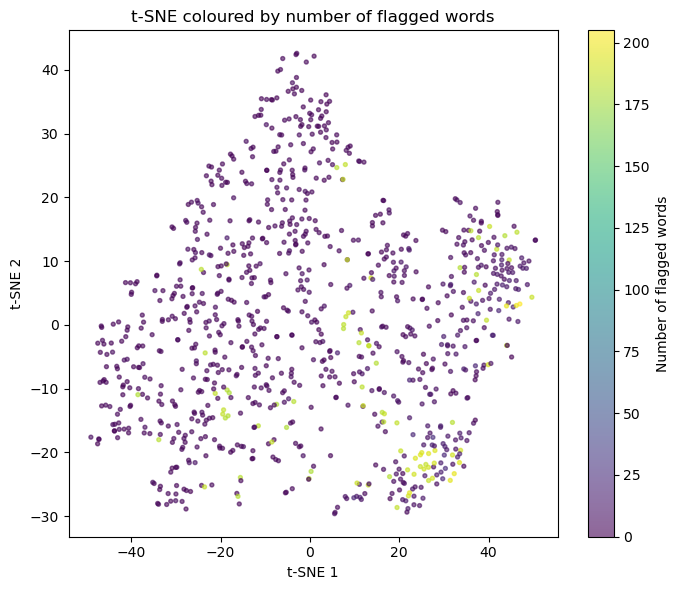

In [ ]:
plt.figure(figsize=(7, 6))

scatter = plt.scatter(
    df_plot['tsne_x'],
    df_plot['tsne_y'],
    c=df_plot['num_flagged_words'],
    cmap='viridis',
    s=8,
    alpha=0.6
)

plt.title('t-SNE coloured by number of flagged words')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

cbar = plt.colorbar(scatter)
cbar.set_label('Number of flagged words')

plt.tight_layout()
plt.show()